Influence of alpha

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from src.stats.from_ilp_log import LoggInfo
from src.utils.params_from_path import params_from_pathlog

loginfo=LoggInfo(times=False, counts=True, sizes=False, usrbintime=True)


NSEQS = 50
# DECOMPOSITION = "row_maximal"
NAME = f"{NSEQS}-SARS-CoV2-MSA"
PATH = Path("/data/analysis-paper/paper-experiment-scalability")

COMPLETE = PATH.joinpath(f"sars-cov-2-{NSEQS}-complete")
ROW_MAXIMAL = PATH.joinpath(f"sars-cov-2-{NSEQS}-row_maximal")

PATH_LOG_PGGB = Path("/data/analysis-paper/experiments/pggb/sars-cov-2/logs/")
PATH_LOG_VG   = Path("/data/analysis-paper/experiments/vg/sars-cov-2/logs/")


In [2]:

## Fontsizes plots
FONTSIZE_TITLE = 18
FONTSIZE_SUBTITLE = 16
FONTSIZE_X = 16
FONTSIZE_Y = 16
FONTSIZE_TOOLS = 14 

FONTSIZE_GRID_TITLE = 18
FONTSIZE_GRID_SUBTITLE = 16
FONTSIZE_GRID_X = 16
FONTSIZE_GRID_Y = 16
FONTSIZE_GRID_TOOLS = 14 

LEGEND = True

In [3]:
PATH_SAVE = Path(f"/data/analysis-paper/output-experiment-scalability/sars-cov-2-{NSEQS}/")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

In [4]:
info_pggb = dict()
for path_log in PATH_LOG_PGGB.glob("*err.log"):
    name = path_log.stem.split("-rule")[0]

    info = loginfo(path_log)["usrbintime"][0]
    info["Max RAM (GB)"] = info["Maximum resident set size (kbytes)"] / 1_000_000
    info["User time (min)"] = round(info["User time (seconds)"]/ 60,0)
    info_pggb[name] = info
info_pggb = info_pggb[NAME]

In [5]:
info_pggb

{'User time (seconds)': 184.05,
 'System time (seconds)': 267.87,
 'Elapsed (wall clock) time (h:mm:ss or m:ss) (seconds)': 61.41,
 'Maximum resident set size (kbytes)': 1245924.0,
 'Max RAM (GB)': 1.245924,
 'User time (min)': 3.0}

In [6]:
info_vg = dict()
for path_log in PATH_LOG_VG.glob("*err.log"):
    name = path_log.stem.split("-rule")[0]

    info = loginfo(path_log)["usrbintime"][0]
    info["Max RAM (GB)"] = info["Maximum resident set size (kbytes)"] / 1_000_000
    info["User time (min)"] = round(info["User time (seconds)"]/ 60,0)
    info_vg[name] = info
info_vg = info_vg[NAME]

In [7]:
list_params = []
for log in ROW_MAXIMAL.joinpath("logs").rglob("*.log"):
    if "rule-ilp" in str(log): # and "nodes" in str(log):
        # print(log)
        params = params_from_pathlog(log)     # pangeblocks params
        params.update( loginfo(log)["usrbintime"][0] ) # logging info 
        params.update( loginfo(log)["counts"][0])
        params["decomposition"] = "row-maximal"
        list_params.append( params)

In [8]:
loginfo(log)["counts"][0]

{'start_end': (27749, 29548),
 'Number of maximal blocks': 194,
 'Number of pairs of overlapping blocks': 8747,
 'Number of missing blocks': 69,
 'Number of blocks one char': 1589,
 'Number of blocks ilp': 3885,
 'Number of C variables': 3885,
 'Number of blocks optimal solution': 127}

In [9]:

for log in COMPLETE.joinpath("logs").rglob("*.log"):
    if "rule-ilp" in str(log) and "nodes" in str(log):
        # print(log)
        params = params_from_pathlog(log)     # pangeblocks params
        params.update( loginfo(log)["usrbintime"][0]  ) # logging info 
        params.update( loginfo(log)["counts"][0])
        params["decomposition"] = "complete"
        list_params.append( params)

In [10]:
loginfo(log)["counts"][0]

{'start_end': (416, 3015),
 'Number of maximal blocks': 3,
 'Number of pairs of overlapping blocks': 2,
 'Number of missing blocks': 51,
 'Number of blocks one char': 101,
 'Number of blocks ilp': 110,
 'Number of C variables': 110,
 'Number of blocks optimal solution': 54}

In [11]:
data = pd.DataFrame(list_params)
data["Max RAM (GB)"] = data["Maximum resident set size (kbytes)"].apply(lambda d: d / 1_000_000)
data["User time (min)"] = data["User time (seconds)"].apply(lambda d: round(d / 60,0))

data["columns"] = data["end"] - data["start"] +1 
data.to_csv(PATH_SAVE.joinpath("usrbintime.tsv"))
data.head(2)


,name,objective_function,penalization,min_len,min_coverage,start,end,User time (seconds),System time (seconds),Elapsed (wall clock) time (h:mm:ss or m:ss) (seconds),...,Number of pairs of overlapping blocks,Number of missing blocks,Number of blocks one char,Number of blocks ilp,Number of C variables,Number of blocks optimal solution,decomposition,Max RAM (GB),User time (min),columns
0,50-sars-cov-2-ena,nodes,0,0,0.0,10645,12044,19.95,1.39,20.58,...,1559,9,1402,2008,2008,34,row-maximal,1.021016,0.0,1400
1,50-sars-cov-2-ena,nodes,0,0,0.0,7545,9444,159.75,0.92,160.44,...,74,55,1070,1134,1134,66,row-maximal,0.206460,3.0,1900


In [12]:
data.groupby("decomposition")[["Max RAM (GB)", "User time (min)"]].describe()

Max RAM (GB)                                                   \
                     count      mean      std       min       25%       50%   
decomposition                                                                 
complete             300.0  3.004714  6.28116  0.054052  0.090248  0.268858   
row-maximal          300.0  0.916178  1.52710  0.053980  0.088137  0.184884   

                                   User time (min)                             \
                    75%        max           count       mean        std  min   
decomposition                                                                   
complete       3.417579  55.379920           300.0  11.760000  59.897033  0.0   
row-maximal    1.261214  11.431644           300.0   1.843333   2.558765  0.0   

                                     
               25%  50%  75%    max  
decomposition                        
complete       0.0  2.0  6.0  635.0  
row-maximal    0.0  1.0  2.0   10.0

In [13]:
data.query("decomposition=='complete' and `Max RAM (GB)`>20")

,name,objective_function,penalization,min_len,min_coverage,start,end,User time (seconds),System time (seconds),Elapsed (wall clock) time (h:mm:ss or m:ss) (seconds),...,Number of pairs of overlapping blocks,Number of missing blocks,Number of blocks one char,Number of blocks ilp,Number of C variables,Number of blocks optimal solution,decomposition,Max RAM (GB),User time (min),columns
310,50-sars-cov-2-ena,nodes,0,0,0.0,25418,28217,2099.19,88.52,1857.28,...,14218,15,2809,26083,26083,50,complete,24.476136,35.0,2800
333,50-sars-cov-2-ena,nodes,0,0,0.0,25432,28131,1710.20,84.65,1538.27,...,12203,15,2708,22791,22791,49,complete,20.865020,29.0,2700
356,50-sars-cov-2-ena,nodes,0,0,0.0,26717,29316,2126.74,95.81,1599.95,...,20083,15,2615,35530,35530,56,complete,21.466488,35.0,2600
372,50-sars-cov-2-ena,nodes,0,0,0.0,16603,19502,2420.45,104.41,1713.80,...,14976,21,2911,27930,27930,71,complete,23.593340,40.0,2900
448,50-sars-cov-2-ena,nodes,0,0,0.0,14722,17721,30247.17,459.90,8633.00,...,20258,22,3004,34206,34206,67,complete,34.683408,504.0,3000
490,50-sars-cov-2-ena,nodes,0,0,0.0,14315,17314,34335.04,575.83,11640.00,...,33071,25,3005,52853,52853,76,complete,55.379920,572.0,3000
563,50-sars-cov-2-ena,nodes,0,0,0.0,14480,17279,38122.10,532.39,10381.00,...,24881,24,2804,40592,40592,71,complete,41.466752,635.0,2800


In [14]:
feature = "Max RAM (GB)"
# min and max y-axis values
feat_min = data[feature].min()
feat_max = max(data[feature].max(), info_pggb[feature], info_vg[feature]) 
delta_range = feat_max - feat_min
ymin = feat_min - 0.1*delta_range 
ymax = feat_max + 0.1*delta_range

## RAM

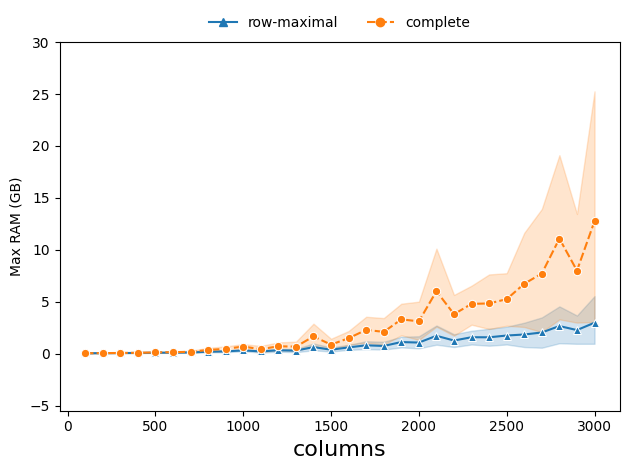

In [15]:
g_ram = sns.lineplot(
    data=data, 
    x="columns", y=feature, 
    hue="decomposition", 
    style="decomposition", 
    markers=["^","o"],
    )# hue_order=OBJ_FUNCTIONS)
# g_ram.text(x=0.5, y=1.1, s=f'{NAME} | Potential seeds of length 15 w.r.t. {chr(945)}', fontsize=FONTSIZE_TITLE, weight='bold', ha='center', va='bottom', transform=g_ram.transAxes)
# g_potential_seeds.text(x=0.5, y=1.05, s=f'Complete vs Row-maximal decomposition | not-{chr(945)}-consistent', fontsize=FONTSIZE_SUBTITLE, alpha=0.75, ha='center', va='bottom', transform=g_potential_seeds.transAxes)
g_ram.set_xlabel(f"columns", fontsize=FONTSIZE_X)
# g_ram.set_ylabel("Max RAM (GB)", fontsize=FONTSIZE_Y)
g_ram.set_ylim([ymin,30])

sns.move_legend(
    g_ram, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

g_ram.figure.tight_layout()
g_ram.get_figure().savefig(PATH_SAVE.joinpath(f"{NAME}-ilp-instances-RAM.png"),dpi=300)

## User Time

In [16]:
feature = "User time (min)"
# min and max y-axis values
feat_min = data[feature].min()
feat_max = max(data[feature].max(), info_pggb[feature], info_vg[feature]) 
delta_range = feat_max - feat_min
ymin = feat_min - 0.01*delta_range 
ymax = feat_max + 0.01*delta_range

In [17]:
ymax

641.35

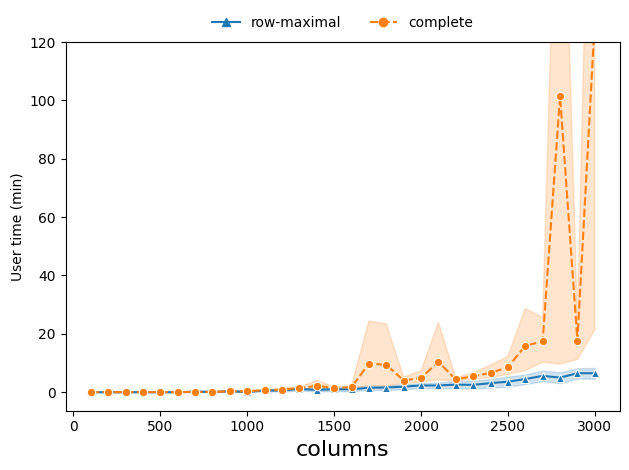

In [18]:
g_time = sns.lineplot(
    data=data,#.query("decomposition!='row-maximal'"), 
    x="columns", y=feature, 
    hue="decomposition", 
    style="decomposition", 
    markers=["^","o"],
    )
g_time.set_xlabel(f"columns", fontsize=FONTSIZE_X)
# g_time.set_ylabel("User time (min)", fontsize=FONTSIZE_Y)
g_time.set_ylim([ymin,120])

sns.move_legend(
    g_time, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

g_time.figure.tight_layout()
g_time.get_figure().savefig(PATH_SAVE.joinpath(f"{NAME}-ilp-instances-User_time.png"),dpi=300)

___
Bivariate plot 

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [20]:
_y = "# variables"
_x = "# columns"

In [21]:
data_plot=data.copy() # .query("decomposition == 'row-maximal'").copy() # query("decomposition == 'row-maximal'")
data_plot[_x] = data_plot["columns"]
data_plot[_y] = data_plot["Number of C variables"] 
# data_plot["# variables"]  = data_plot["Number of C variables"]

bin_ram=[1,5,10,15,20,100]
bin_ram_label=[f"{x}" for x in bin_ram[:-1] ]
data_plot["RAM"] = pd.cut(data["Max RAM (GB)"], bin_ram, labels=bin_ram_label)

bin_time=[1,10,15,30,60,1800]
bin_time_label=[f"{x}" for x in bin_time[:-1] ]
data_plot["User time"] = pd.cut(data["User time (seconds)"], bin_time, labels=bin_time_label)


bin_var=[x for x in range(1000,400001, 1000)]
bin_var_label=[f"{x}" for x in bin_var[:-1] ]# "<10","<30","<60","<180","<600"]
data_plot["variables"] = pd.cut(data_plot["# variables"], bin_var, labels=bin_var_label)

In [22]:

# # Draw a combo histogram and scatterplot with density contours
# f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(
#     data_plot, 
#     x=x, y=y, s=20, color="1.2.", 
#     hue="User time",
#     style="decomposition", markers=["D", "o"],
#     palette="rocket_r"
#     )

/tmp/ipykernel_1767988/3239514577.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  rp_time = sns.relplot(


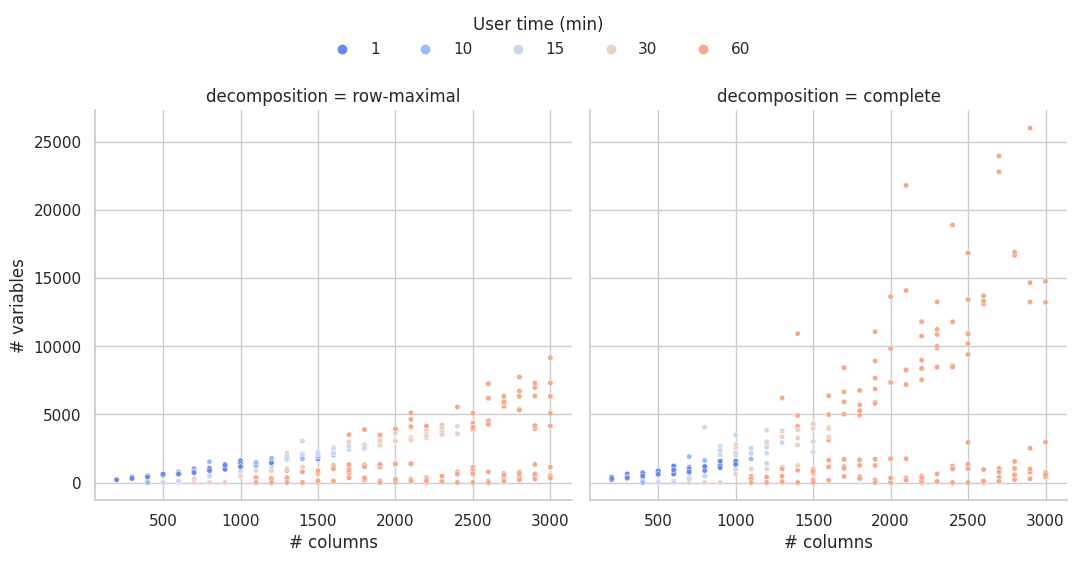

In [57]:
rp_time = sns.relplot(
    data_plot, 
    x=_x, y=_y, s=15, color="1.2.", 
    hue="User time",
    # palette=sns.diverging_palette(220, 20, center = "dark", as_cmap=False),
    # palette=sns.color_palette("Spectral", as_cmap=False),
    palette=sns.color_palette("coolwarm", as_cmap=False,),
    kind="scatter",
    col="decomposition",
    # alpha=0.3,
    )

# rp_time.set_xlabel(f"# columns", fontsize=FONTSIZE_X)
# rp_time.set_ylabel("# decision variables", fontsize=FONTSIZE_Y)

sns.move_legend(
    rp_time, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title="User time (min)", frameon=False,
)

rp_time.figure.tight_layout()
rp_time.savefig(PATH_SAVE.joinpath(f"{NAME}-user_time-scatter.png"),dpi=300)

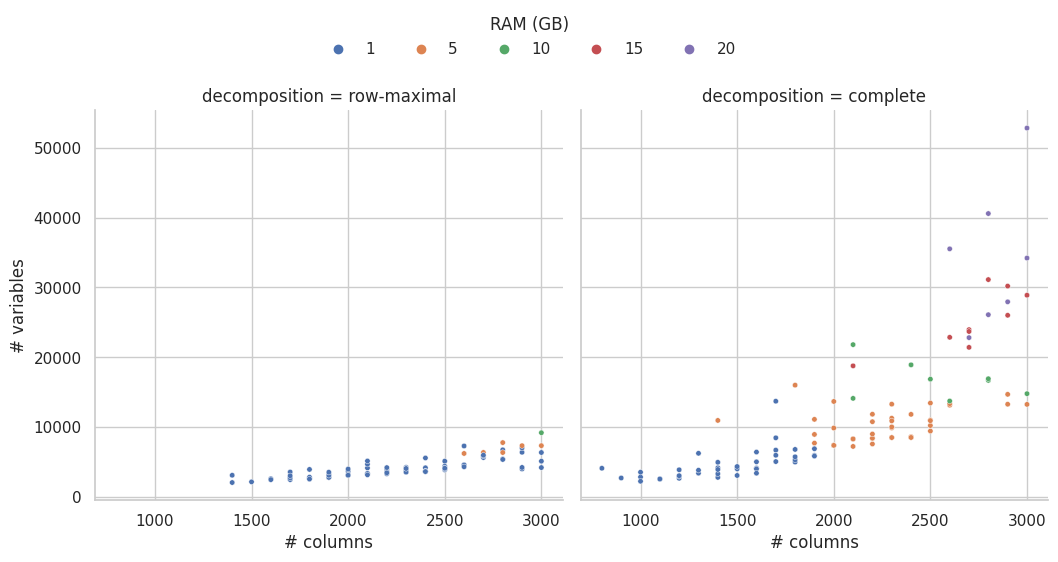

In [39]:
rp_ram = sns.relplot(
    data_plot, 
    x=_x, y=_y, s=15, color="1.2.", 
    hue="RAM",
    # palette=sns.light_palette("#79C"),
    kind="scatter",
    col="decomposition",
    )

sns.move_legend(
    rp_ram, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title="RAM (GB)", frameon=False,
)

rp_ram.figure.tight_layout()
rp_ram.savefig(PATH_SAVE.joinpath(f"{NAME}-ram-scatter.png"),dpi=300)